In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


import ncut_loss
import build_Unet
import build_Wnet
import getData

from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

from getData import get_generator
import tensorflow_addons as tfa

In [147]:
# DATASETS

TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_4.json"]


damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True,
 n_holes=1,max_height=100,max_width=100,min_width = 50,min_height = 50,fill_value_mode = "un")
non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False,
    n_holes=1,max_height=100,max_width=100,min_width = 50,min_height = 50,fill_value_mode = "un")



In [148]:

def rescale(image):
    return( (((np.array(image)+1)/2)*255 ).astype("uint8") )

In [163]:
imgs,imgs_cutout = non_damaged_generator.__getitem__(np.random.randint(1,1000))

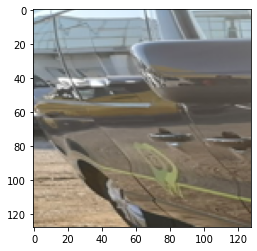

In [164]:
plt.imshow(rescale(imgs[0]))

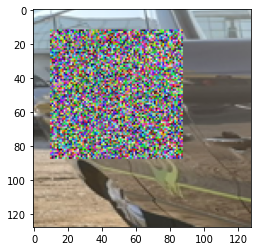

In [165]:
plt.imshow(rescale(imgs_cutout[0]))

In [42]:
import numpy as np
class Cutout(object):
    def __init__(self, n_holes, max_height, max_width, min_height=None, min_width=None,
                 fill_value_mode='zero', p=0.5):
        self.n_holes = n_holes
        self.max_height = max_height
        self.max_width = max_width
        self.min_width = min_width if min_width is not None else max_width
        self.min_height = min_height if min_height is not None else max_height
        self.fill_value_mode = fill_value_mode  # 'zero' 'one' 'uniform'
        

    def __call__(self, img ):
       

        h = img.shape[0]
        w = img.shape[1]

        if self.fill_value_mode == 'zero':
            f = np.zeros
            param = {'shape': (h, w, 3)}
        elif self.fill_value_mode == 'one':
            f = np.one
            param = {'shape': (h, w, 3)}
        else:
            f = np.random.uniform
            param = {'low': 0, 'high': 255, 'size': (h, w, 3)}

        mask = np.ones((h, w, 3), dtype=np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            h_l = np.random.randint(self.min_height, self.max_height + 1)
            w_l = np.random.randint(self.min_width, self.max_width + 1)

            y1 = np.clip(y - h_l // 2, 0, h)
            y2 = np.clip(y + h_l // 2, 0, h)
            x1 = np.clip(x - w_l // 2, 0, w)
            x2 = np.clip(x + w_l // 2, 0, w)

            mask[y1:y2, x1:x2, :] = 0

        img = np.where(mask, img, f(**param))
       
        return np.float32(img)

In [55]:
c = Cutout(1,100,100,60,60,'zero',0)

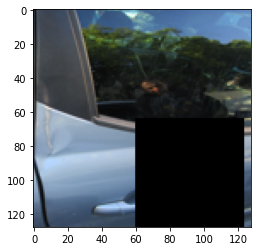

In [71]:
res = c(img)
plt.imshow(res)

In [72]:
res.shape

[autoreload of getData failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/jeremy/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/envs/jeremy/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/envs/jeremy/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/envs/jeremy/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

(128, 128, 3)